# Forecast Hybrid Production Notebook
Author: George Panagiotou

In [1]:
import pandas as pd
import numpy as np
from comp_utils import *
import lightgbm as lgb
import os

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

## Test and train data:

In [2]:
Wind_train1 = pd.read_csv('data/LightGB/Wind_quantiles_train_set.csv')
Wind_train1 = Wind_train1.rename(columns={'q10': '1_qw10','q20': '1_qw20','q30': '1_qw30','q40': '1_qw40','q50': '1_qw50','q60': '1_qw60','q70': '1_qw70','q80': '1_qw80','q90': '1_qw90' }) 
Solar_train1 = pd.read_csv('data/LightGB/Solar_quantiles_train_set.csv')
Solar_train1 = Solar_train1.rename(columns={'q10': '1_qs10','q20': '1_qs20','q30': '1_qs30','q40': '1_qs40','q50': '1_qs50','q60': '1_qs60','q70': '1_qs70','q80': '1_qs80','q90': '1_qs90' }) 

Train_set = Solar_train1.merge(Wind_train1, on='time')

Wind_train2 = pd.read_csv('data/ExtremeGB/Wind_quantiles_train_set.csv')
Wind_train2 = Wind_train2.rename(columns={'q10': '2_qw10','q20': '2_qw20','q30': '2_qw30','q40': '2_qw40','q50': '2_qw50','q60': '2_qw60','q70': '2_qw70','q80': '2_qw80','q90': '2_qw90' })
Wind_train2 = Wind_train2.drop(columns=['Wind_MWh_credit'])

Solar_train2 = pd.read_csv('data/ExtremeGB/Solar_quantiles_train_set.csv')
Solar_train2 = Solar_train2.rename(columns={'q10': '2_qs10','q20': '2_qs20','q30': '2_qs30','q40': '2_qs40','q50': '2_qs50','q60': '2_qs60','q70': '2_qs70','q80': '2_qs80','q90': '2_qs90' }) 
Solar_train2 = Solar_train2.drop(columns=['Solar_MWh_credit'])


Wind_train3 = pd.read_csv('data/LinearQ/Wind_train_quantiles.csv')
Wind_train3 = Wind_train3.rename(columns={'q10': '3_qw10','q20': '3_qw20','q30': '3_qw30','q40': '3_qw40','q50': '3_qw50','q60': '3_qw60','q70': '3_qw70','q80': '3_qw80','q90': '3_qw90' })
Wind_train3 = Wind_train3.drop(columns=['Wind_MWh_credit'])

Solar_train3 = pd.read_csv('data/LinearQ/Solar_train_quantiles.csv')
Solar_train3 = Solar_train3.rename(columns={'q10': '3_qs10','q20': '3_qs20','q30': '3_qs30','q40': '3_qs40','q50': '3_qs50','q60': '3_qs60','q70': '3_qs70','q80': '3_qs80','q90': '3_qs90' }) 
Solar_train3 = Solar_train3.drop(columns=['Solar_MWh_credit'])

Train_set = Train_set.merge(Wind_train2, on='time')
Train_set = Train_set.merge(Solar_train2, on='time')
Train_set = Train_set.merge(Wind_train3, on='time')
Train_set = Train_set.merge(Solar_train3, on='time')
train_target_variable = Train_set['Wind_MWh_credit'] + Train_set['Solar_MWh_credit']

Train_set = Train_set.rename(columns={'time':'valid_time'})
Train_set['valid_time'] = pd.to_datetime(Train_set['valid_time'])
train_times = Train_set['valid_time']
Train_set = add_cyclic_features(Train_set)
Train_set = Train_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Train features after removing columns:', Train_set.shape)

Train features after removing columns: (56284, 63)


In [3]:
# Read and rename test datasets
Wind_test1 = pd.read_csv('data/LightGB/Wind_quantiles_test_set.csv')
Wind_test1 = Wind_test1.rename(columns={'q10': '1_qw10', 'q20': '1_qw20', 'q30': '1_qw30', 'q40': '1_qw40', 'q50': '1_qw50', 'q60': '1_qw60', 'q70': '1_qw70', 'q80': '1_qw80', 'q90': '1_qw90'})
Solar_test1 = pd.read_csv('data/LightGB/Solar_quantiles_test_set.csv')
Solar_test1 = Solar_test1.rename(columns={'q10': '1_qs10', 'q20': '1_qs20', 'q30': '1_qs30', 'q40': '1_qs40', 'q50': '1_qs50', 'q60': '1_qs60', 'q70': '1_qs70', 'q80': '1_qs80', 'q90': '1_qs90'})

Test_set = Solar_test1.merge(Wind_test1, on='time')

Wind_test2 = pd.read_csv('data/ExtremeGB/Wind_quantiles_test_set.csv')
Wind_test2 = Wind_test2.rename(columns={'q10': '2_qw10', 'q20': '2_qw20', 'q30': '2_qw30', 'q40': '2_qw40', 'q50': '2_qw50', 'q60': '2_qw60', 'q70': '2_qw70', 'q80': '2_qw80', 'q90': '2_qw90'})
Wind_test2 = Wind_test2.drop(columns=['Wind_MWh_credit'])

Solar_test2 = pd.read_csv('data/ExtremeGB/Solar_quantiles_test_set.csv')
Solar_test2 = Solar_test2.rename(columns={'q10': '2_qs10', 'q20': '2_qs20', 'q30': '2_qs30', 'q40': '2_qs40', 'q50': '2_qs50', 'q60': '2_qs60', 'q70': '2_qs70', 'q80': '2_qs80', 'q90': '2_qs90'})
Solar_test2 = Solar_test2.drop(columns=['Solar_MWh_credit'])

Wind_test3 = pd.read_csv('data/LinearQ/Wind_test_quantiles.csv')
Wind_test3 = Wind_test3.rename(columns={'q10': '3_qw10', 'q20': '3_qw20', 'q30': '3_qw30', 'q40': '3_qw40', 'q50': '3_qw50', 'q60': '3_qw60', 'q70': '3_qw70', 'q80': '3_qw80', 'q90': '3_qw90'})
Wind_test3 = Wind_test3.drop(columns=['Wind_MWh_credit'])

Solar_test3 = pd.read_csv('data/LinearQ/Solar_test_quantiles.csv')
Solar_test3 = Solar_test3.rename(columns={'q10': '3_qs10', 'q20': '3_qs20', 'q30': '3_qs30', 'q40': '3_qs40', 'q50': '3_qs50', 'q60': '3_qs60', 'q70': '3_qs70', 'q80': '3_qs80', 'q90': '3_qs90'})
Solar_test3 = Solar_test3.drop(columns=['Solar_MWh_credit'])

Test_set = Test_set.merge(Wind_test2, on='time')
Test_set = Test_set.merge(Solar_test2, on='time')
Test_set = Test_set.merge(Wind_test3, on='time')
Test_set = Test_set.merge(Solar_test3, on='time')
test_target_variable = Test_set['Wind_MWh_credit'] + Test_set['Solar_MWh_credit']

Test_set = Test_set.rename(columns={'time': 'valid_time'})
Test_set['valid_time'] = pd.to_datetime(Test_set['valid_time'])
test_times = Test_set['valid_time']
Test_set = add_cyclic_features(Test_set)
Test_set = Test_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Test features after removing columns:', Test_set.shape)


Test features after removing columns: (4318, 63)


## LightGBM (Tuning)
!!!DO NOT RUN !!!

In [4]:
search_spaces = {
    'learning_rate': Real(0.01, 0.5, 'uniform'),
    'max_depth': Integer(-7, 7), 
    'n_estimators': Integer(100, 400), 
    'num_leaves': Integer(20, 70)
}

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_models = {}

# Function to compute pinball loss
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Perform Bayesian optimization search for each quantile
for quantile in quantiles:
    print(f"Running Bayesian optimization search for the {quantile * 100}% quantile.")
    model = lgb.LGBMRegressor(
        objective='quantile',
        alpha=quantile,
        verbose=-1
    )
    custom_scorer = make_scorer(pinball_loss, greater_is_better=False, alpha=quantile)
    kf = KFold(n_splits=5)
    
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=16,  
        cv=kf,  
        scoring=custom_scorer,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )
    optimizer.fit(Train_set, train_target_variable)
    best_model = optimizer.best_estimator_
    model_path = f'models/LightGB/LGBR_W&S_ALL_q{int(quantile * 100)}.txt'
    best_model.booster_.save_model(model_path)
    print(f"Best parameters for {quantile * 100}% quantile: {optimizer.best_params_}")
    best_models[f'q{int(quantile*100)}'] = best_model

    # Retrieve and print CV error for the optimal model
    mean_test_score = optimizer.cv_results_['mean_test_score'][optimizer.best_index_]
    mean_train_score = optimizer.cv_results_['mean_train_score'][optimizer.best_index_]
    print(f"CV error for {quantile * 100}% quantile: {mean_test_score}")
    print(f"Training error for {quantile * 100}% quantile: {mean_train_score}")

print("Optimization complete. Best models saved.")

Running Bayesian optimization search for the 10.0% quantile.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for 10.0% quantile: OrderedDict([('learning_rate', 0.10418260762150819), ('max_depth', -6), ('n_est

/home/thesis/George/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for 40.0% quantile: OrderedDict([('learning_rate', 0.15148420538667098), ('max_depth', 7), ('n_estimators', 400), ('num_leaves', 20)])
CV error for 40.0% quantile: -25.300854984021207
Training error for 40.0% quantile: -21.323810528238283
Running Bayesian optimization search for the 50.0% quantile.
Fitting 5 folds for each of 1 candi

## Train set

In [4]:
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = train_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/LightGB/LGBR_W&S_ALL_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Train_set)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print('Training Loss(Quantile):',pinball_score(quantile_predictions_df,target_col='total_generation_MWh'))

quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/LightGB/Final_LGBR_quantiles_train_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)


Training Loss(Quantile): 17.147993011651593


In [5]:
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/LightGB/LGBR_W&S_ALL_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Test_set)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print('Test Loss(Quantile):',pinball_score(quantile_predictions_df,target_col='total_generation_MWh'))

quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/LightGB/Final_LGBR_quantiles_test_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Test Loss(Quantile): 23.342302207977433


## Plot Quantiles ( Probabilistic Forecasting) : 

In [6]:
save_path = "plots/LightGB/W&S_LGBR_ALL_Plot_Quantiles.html"
graph_title = "Hybrid Production Forecast (LightGBM-3)"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'total_generation_MWh', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

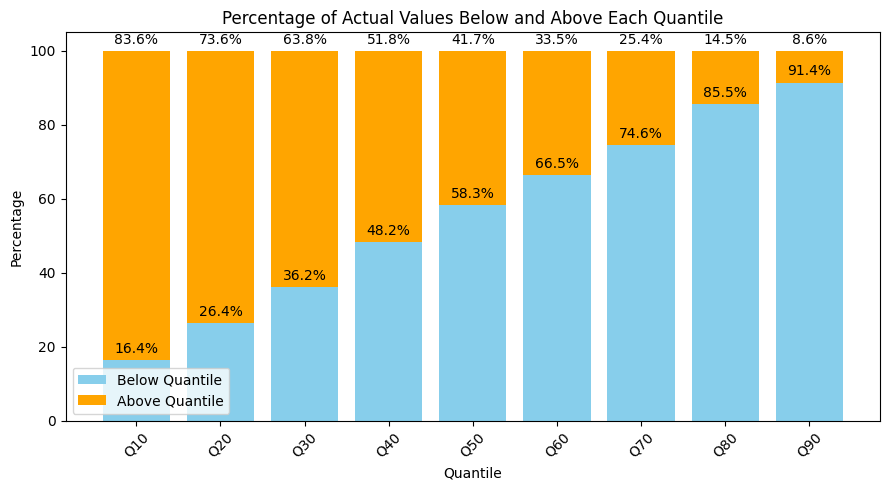

In [7]:
quantile_stats(quantile_predictions_df)

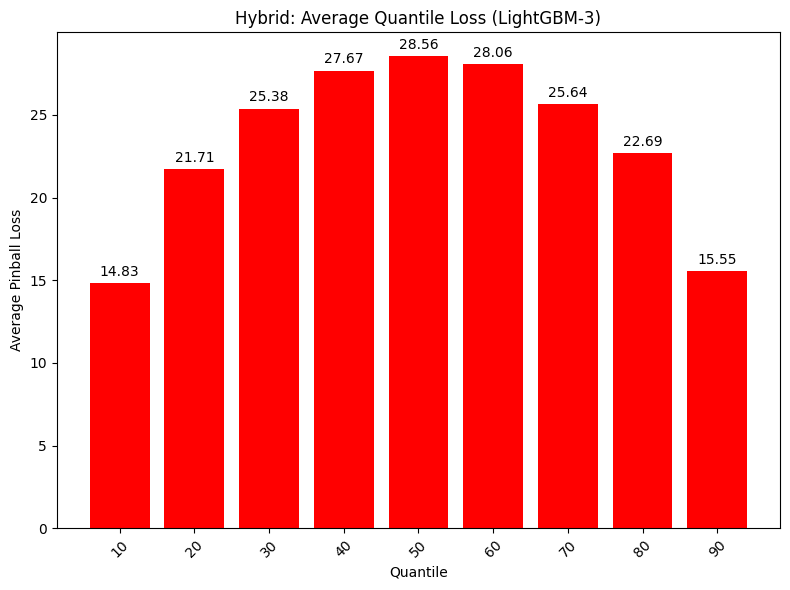

In [8]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'total_generation_MWh', "Hybrid: Average Quantile Loss (LightGBM-3)")

/tmp/ipykernel_879584/3733446719.py:25: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



23.78175615291641


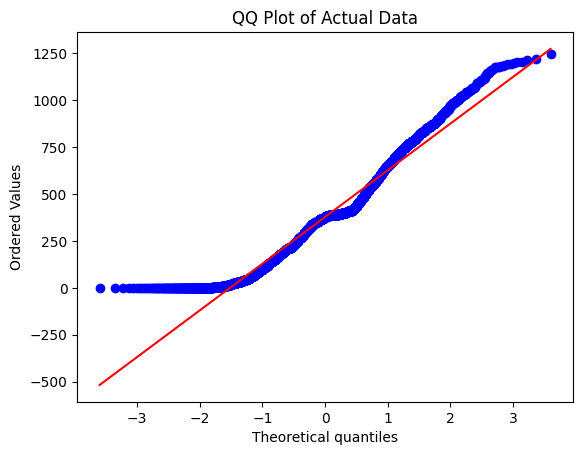

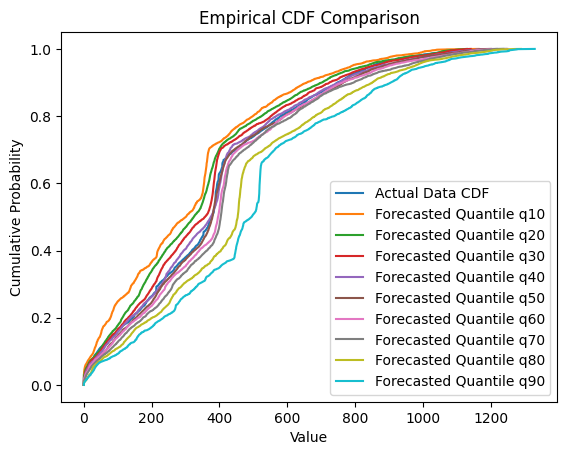

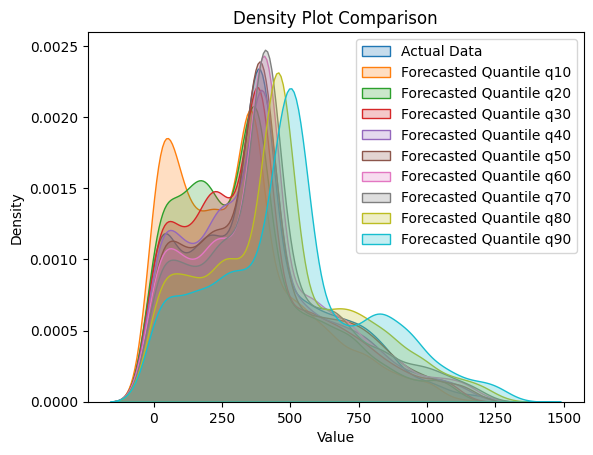

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import lightgbm as lgb
from statsmodels.distributions.empirical_distribution import ECDF

# Your existing code for loading models and making predictions
saved_models_dir = 'saved_models'
os.makedirs(saved_models_dir, exist_ok=True)

quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/LightGB/LGBR_W&S_ALL_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Test_set)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].applymap(lambda x: max(x, 0))

# Ensure the columns are sorted by quantile
quantile_predictions_df = quantile_predictions_df[['total_generation_MWh'] + sorted(quantile_columns)]

# Print pinball score (assuming this function is defined elsewhere)
print(pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

# Add time column (assuming test_times is defined)
quantile_predictions_df['time'] = test_times

# Plotting the required plots

# Quantile-Quantile (QQ) Plot
fig, ax = plt.subplots()
stats.probplot(quantile_predictions_df['total_generation_MWh'], dist="norm", plot=ax)
ax.set_title('QQ Plot of Actual Data')
plt.show()

# Cumulative Distribution Function (CDF) Plot
ecdf_actual = ECDF(quantile_predictions_df['total_generation_MWh'])
plt.figure()
plt.plot(ecdf_actual.x, ecdf_actual.y, label='Actual Data CDF')
for qu in quantiles:
    ecdf_forecast = ECDF(quantile_predictions_df[f'q{qu}'])
    plt.plot(ecdf_forecast.x, ecdf_forecast.y, label=f'Forecasted Quantile q{qu}')
plt.title('Empirical CDF Comparison')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

# Density Plot
plt.figure()
sns.kdeplot(quantile_predictions_df['total_generation_MWh'], label='Actual Data', fill=True)
for qu in quantiles:
    sns.kdeplot(quantile_predictions_df[f'q{qu}'], label=f'Forecasted Quantile q{qu}', fill=True)
plt.title('Density Plot Comparison')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


/tmp/ipykernel_879584/2202193433.py:20: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/tmp/ipykernel_879584/2202193433.py:27: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



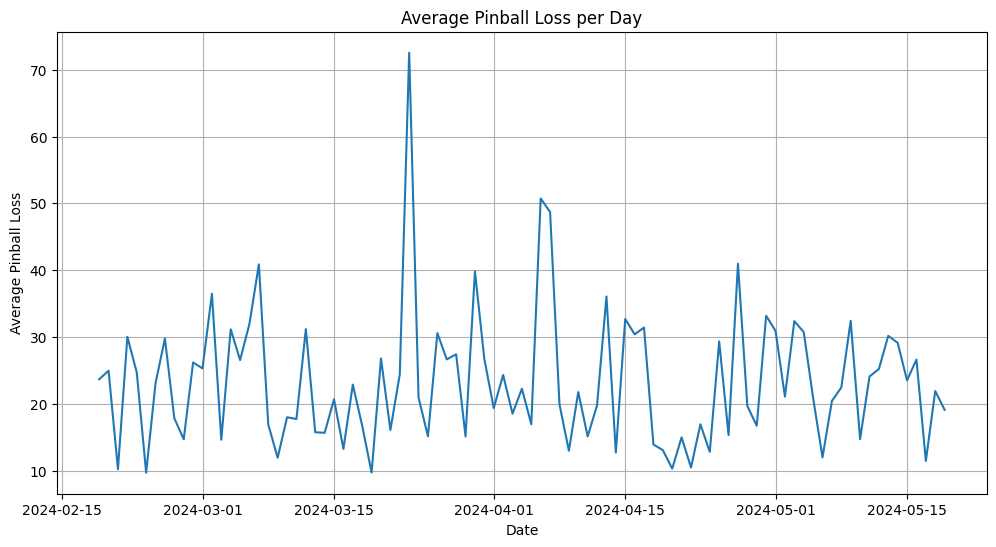

In [11]:
import os
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

saved_models_dir = 'saved_models'
os.makedirs(saved_models_dir, exist_ok=True)

quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/LightGB/LGBR_W&S_ALL_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(Test_set)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].applymap(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

quantile_predictions_df['time'] = test_times  

# Group by day and calculate the average pinball loss per day
quantile_predictions_df['date'] = quantile_predictions_df['time'].dt.date
average_pinball_loss_per_day = quantile_predictions_df.groupby('date').apply(lambda df: pinball_score(df, target_col='total_generation_MWh'))

# Plot the average pinball loss per day
plt.figure(figsize=(12, 6))
average_pinball_loss_per_day.plot()
plt.xlabel('Date')
plt.ylabel('Average Pinball Loss')
plt.title('Average Pinball Loss per Day')
plt.grid(True)
plt.show()

#csv_file_path = 'WSE_quantiles_train_set.csv'
#quantile_predictions_df.to_csv(csv_file_path, index=False)
